In [1]:

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import os
import seaborn as sns

In [2]:
# Declare input file paths and file names
pga_data_hist_file = os.path.join(".", "input_data", "PGA_Data_Historical.csv")
player_exp_file = os.path.join(".", "input_data", "player_experience_data.csv")

In [3]:
# Load main player and stat data into dataframe
all_pga_data_df = pd.read_csv(pga_data_hist_file)

# Load player experience lookup table
player_exp_df = pd.read_csv(player_exp_file)

In [4]:
# Merge player experience into main dataframe
all_pga_data_df = all_pga_data_df.merge(player_exp_df, how='left', on="Player Name")

all_pga_data_df.head()

,Player Name,Season,Statistic,Variable,Value,Exp-Before-2010,Exp-Less_Eq-2012,Exp-Less_Eq-2015,Exp-Less_Eq-2018
0,Robert Garrigus,2010,Driving Distance,Driving Distance - (ROUNDS),71,4.0,7.0,10.0,13.0
1,Bubba Watson,2010,Driving Distance,Driving Distance - (ROUNDS),77,4.0,7.0,10.0,13.0
2,Dustin Johnson,2010,Driving Distance,Driving Distance - (ROUNDS),83,2.0,5.0,8.0,11.0
3,Brett Wetterich,2010,Driving Distance,Driving Distance - (ROUNDS),54,6.0,9.0,9.0,9.0
4,J.B. Holmes,2010,Driving Distance,Driving Distance - (ROUNDS),100,4.0,7.0,10.0,13.0


In [5]:

# Define list of stats to keep
keep_variable_stats =  ["Season",
                        "Driving Distance - (AVG.)",
                        "Driving Distance - (TOTAL DRIVES)",
                        "Total Driving - (TOTAL)",
                        "Total Driving - (DISTANCE RANK)",
                        "Total Driving - (ACCURACY RANK)",
                        "Smash Factor - (AVG.)",
                        "Short Game Rating - (RATING)",
                        "Proximity to Hole (ARG) - (AVG DTP)",
                        "Total Putting - (TOTAL)",
                        "Putting Average - (AVG)",
                        "Total Money (Official and Unofficial) - (MONEY)"]

# Define count of stats we are keeping for each player
desired_var_stats_cnt = len(keep_variable_stats)

# Create filtered dataframe
temp_filtered_stats = all_pga_data_df.copy()
temp_filtered_stats = temp_filtered_stats.loc[temp_filtered_stats["Variable"].isin(keep_variable_stats),:]

# Drop the Statistic column, and just keep the Variable column
temp_filtered_stats.drop(["Statistic"], axis=1, inplace=True)

# Rename Variable column
temp_filtered_stats.rename(columns={"Variable" : "Statistic"}, inplace=True)

temp_filtered_stats.head()

,Player Name,Season,Statistic,Value,Exp-Before-2010,Exp-Less_Eq-2012,Exp-Less_Eq-2015,Exp-Less_Eq-2018
192,Robert Garrigus,2010,Driving Distance - (AVG.),315.5,4.0,7.0,10.0,13.0
193,Bubba Watson,2010,Driving Distance - (AVG.),309.8,4.0,7.0,10.0,13.0
194,Dustin Johnson,2010,Driving Distance - (AVG.),308.5,2.0,5.0,8.0,11.0
195,Brett Wetterich,2010,Driving Distance - (AVG.),307.3,6.0,9.0,9.0,9.0
196,J.B. Holmes,2010,Driving Distance - (AVG.),307.2,4.0,7.0,10.0,13.0


In [6]:
# Create new dataframe to move our statistics from row values to columns

# Define columns of the new dataframe
desired_columns_lst = ["Player Name",
                       "Season",
                       "Driving Distance - (AVG.)", 
                       "Driving Distance - (TOTAL DRIVES)",
                       "Total Driving - (TOTAL)",
                       "Total Driving - (DISTANCE RANK)",
                       "Total Driving - (ACCURACY RANK)",
                       "Smash Factor - (AVG.)",
                       "Short Game Rating - (RATING)",
                       "Proximity to Hole (ARG) - (AVG DTP)",
                       "Total Putting - (TOTAL)",
                       "Putting Average - (AVG)",
                       "Total Money (Official and Unofficial) - (MONEY)",
                       "Exp-Before-2010",
                       "Exp-Less_Eq-2012",
                       "Exp-Less_Eq-2015",
                       "Exp-Less_Eq-2018"]
                
cln_all_pga_data_df = pd.DataFrame(columns = desired_columns_lst)


for index, rows in temp_filtered_stats.iterrows():  
    # Search if name and season is in the dataframe, if not add
    search = cln_all_pga_data_df.loc[(cln_all_pga_data_df["Player Name"] == rows["Player Name"]) & (cln_all_pga_data_df["Season"] == rows["Season"])]
    if len(search) == 0:
        # Name and season not found.  Insert name, season, and statistic
        data = [{"Player Name" : rows["Player Name"],
                 "Season" : rows["Season"],
                 rows["Statistic"] : rows["Value"],
                 "Exp-Before-2010" : rows["Exp-Before-2010"],
                 "Exp-Less_Eq-2012" : rows["Exp-Less_Eq-2012"],
                 "Exp-Less_Eq-2015" : rows["Exp-Less_Eq-2015"],
                 "Exp-Less_Eq-2018" : rows["Exp-Less_Eq-2018"]}]            
        cln_all_pga_data_df = cln_all_pga_data_df.append(data, ignore_index=True, sort=False)
    else:
        # Name and season found.  Just add the statistic
        cln_all_pga_data_df.loc[(cln_all_pga_data_df["Player Name"] == rows["Player Name"]) & (cln_all_pga_data_df["Season"] == rows["Season"]), rows["Statistic"]] = rows["Value"]

In [7]:
# Data cleaning - Drop rows with NaN values
cln_all_pga_data_df.dropna(axis=0, how='any', inplace=True)


# Data cleaning - Convert the Proximity to Hole (ARG) - (AVG DTP) to inches
# Define function to perform conversion
def conv_dtp_to_inches(input_dtp):
    split_str = input_dtp.split("' ")
    feet = float(split_str[0])
    inches = float(split_str[1].replace("\"",""))
    return (12 * feet) + inches

cln_all_pga_data_df["Proximity to Hole (ARG) - (AVG DTP) (IN)"] = cln_all_pga_data_df["Proximity to Hole (ARG) - (AVG DTP)"].apply(lambda x:conv_dtp_to_inches(x))

# Drop old Proximity to Hole (ARG) - (AVG DTP) column
cln_all_pga_data_df.drop("Proximity to Hole (ARG) - (AVG DTP)", axis=1, inplace=True)


# Data cleaning - Remove dollar sign and commas from earnings column

cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"] = cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"].str.replace('$','')
cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"] = cln_all_pga_data_df["Total Money (Official and Unofficial) - (MONEY)"].str.replace(',','')

In [8]:
cln_all_pga_data_df.head()

,Player Name,Season,Driving Distance - (AVG.),Driving Distance - (TOTAL DRIVES),Total Driving - (TOTAL),Total Driving - (DISTANCE RANK),Total Driving - (ACCURACY RANK),Smash Factor - (AVG.),Short Game Rating - (RATING),Total Putting - (TOTAL),Putting Average - (AVG),Total Money (Official and Unofficial) - (MONEY),Exp-Before-2010,Exp-Less_Eq-2012,Exp-Less_Eq-2015,Exp-Less_Eq-2018,Proximity to Hole (ARG) - (AVG DTP) (IN)
0,Robert Garrigus,2010,315.5,130,176,1,175,1.475,5.5,245.2,1.786,1583275,4.0,7.0,10.0,13.0,103.0
1,Bubba Watson,2010,309.8,154,178,2,176,1.477,5.6,219.9,1.763,3655665,4.0,7.0,10.0,13.0,97.0
2,Dustin Johnson,2010,308.5,164,175,3,172,1.479,5.8,239.6,1.767,5280289,2.0,5.0,8.0,11.0,94.0
3,Brett Wetterich,2010,307.3,108,166,4,162,1.477,6.0,200.0,1.801,510672,6.0,9.0,9.0,9.0,97.0
4,J.B. Holmes,2010,307.2,200,188,5,183,1.480,6.2,234.8,1.770,2746248,4.0,7.0,10.0,13.0,84.0


In [9]:
# Rearrange columns
column_order = ["Player Name",
                "Season",
                "Driving Distance - (AVG.)",
                "Driving Distance - (TOTAL DRIVES)",
                "Total Driving - (TOTAL)",
                "Total Driving - (DISTANCE RANK)",
                "Total Driving - (ACCURACY RANK)",
                "Smash Factor - (AVG.)",
                "Short Game Rating - (RATING)",
                "Proximity to Hole (ARG) - (AVG DTP) (IN)",
                "Total Putting - (TOTAL)",
                "Putting Average - (AVG)",
                "Total Money (Official and Unofficial) - (MONEY)",
                "Exp-Before-2010",
                "Exp-Less_Eq-2012",
                "Exp-Less_Eq-2015",
                "Exp-Less_Eq-2018"]

cln_all_pga_data_df = cln_all_pga_data_df.reindex(columns=column_order)

In [10]:
cln_all_pga_data_df.head()

,Player Name,Season,Driving Distance - (AVG.),Driving Distance - (TOTAL DRIVES),Total Driving - (TOTAL),Total Driving - (DISTANCE RANK),Total Driving - (ACCURACY RANK),Smash Factor - (AVG.),Short Game Rating - (RATING),Proximity to Hole (ARG) - (AVG DTP) (IN),Total Putting - (TOTAL),Putting Average - (AVG),Total Money (Official and Unofficial) - (MONEY),Exp-Before-2010,Exp-Less_Eq-2012,Exp-Less_Eq-2015,Exp-Less_Eq-2018
0,Robert Garrigus,2010,315.5,130,176,1,175,1.475,5.5,103.0,245.2,1.786,1583275,4.0,7.0,10.0,13.0
1,Bubba Watson,2010,309.8,154,178,2,176,1.477,5.6,97.0,219.9,1.763,3655665,4.0,7.0,10.0,13.0
2,Dustin Johnson,2010,308.5,164,175,3,172,1.479,5.8,94.0,239.6,1.767,5280289,2.0,5.0,8.0,11.0
3,Brett Wetterich,2010,307.3,108,166,4,162,1.477,6.0,97.0,200.0,1.801,510672,6.0,9.0,9.0,9.0
4,J.B. Holmes,2010,307.2,200,188,5,183,1.480,6.2,84.0,234.8,1.770,2746248,4.0,7.0,10.0,13.0


In [11]:
# Convert stat columns to appropriate datatypes

# Define a conversion dictionary
conversion_dict = {"Season" : "int64",
                   "Driving Distance - (AVG.)" : "float64",
                   "Driving Distance - (TOTAL DRIVES)" : "int64",
                   "Total Driving - (TOTAL)" : "int64",
                   "Total Driving - (DISTANCE RANK)" : "int64",
                   "Total Driving - (ACCURACY RANK)" : "int64",
                   "Smash Factor - (AVG.)" : "float64",
                   "Short Game Rating - (RATING)" : "float64",
                   "Proximity to Hole (ARG) - (AVG DTP) (IN)" : "float64",
                   "Total Putting - (TOTAL)" : "float64",
                   "Putting Average - (AVG)" : "float64",
                   "Total Money (Official and Unofficial) - (MONEY)" : "float64",
                   "Exp-Before-2010" : "int64",
                   "Exp-Less_Eq-2012" : "int64",
                   "Exp-Less_Eq-2015" : "int64",
                   "Exp-Less_Eq-2018" : "int64"                   
                 }

# Convert column datatypes, ignore errors and keep any NaNs if they exist
cln_all_pga_data_df = cln_all_pga_data_df.astype(conversion_dict, errors="ignore")

cln_all_pga_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1661 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Player Name                                      1661 non-null   object 
 1   Season                                           1661 non-null   int64  
 2   Driving Distance - (AVG.)                        1661 non-null   float64
 3   Driving Distance - (TOTAL DRIVES)                1661 non-null   int64  
 4   Total Driving - (TOTAL)                          1661 non-null   int64  
 5   Total Driving - (DISTANCE RANK)                  1661 non-null   int64  
 6   Total Driving - (ACCURACY RANK)                  1661 non-null   int64  
 7   Smash Factor - (AVG.)                            1661 non-null   float64
 8   Short Game Rating - (RATING)                     1661 non-null   float64
 9   Proximity to Hole (ARG) - (AVG

In [12]:

# Output to CSV or Read from CSV using this cell

#cln_all_pga_data_df.to_csv("output_data/cln_all_pga_data_df.csv", index=False)

In [13]:
# If we need these, this is how to split our dataframe into groups

# Create dataframes for groups of 3 years
cln_2010_2012_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2010", "2011", "2012"]),:]
cln_2010_2012_df.reset_index(inplace=True)

cln_2013_2015_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2013", "2014", "2015"]),:]
cln_2013_2015_df.reset_index(inplace=True)

cln_2016_2018_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2016", "2017", "2018"]),:]
cln_2016_2018_df.reset_index(inplace=True)

# Create dataframes for groups of 4 years
cln_2011_2014_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2011", "2012", "2013", "2014"]),:]
cln_2011_2014_df.reset_index(inplace=True)

cln_2015_2018_df = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"].isin(["2015", "2016", "2017", "2018"]),:]
cln_2015_2018_df.reset_index(inplace=True)

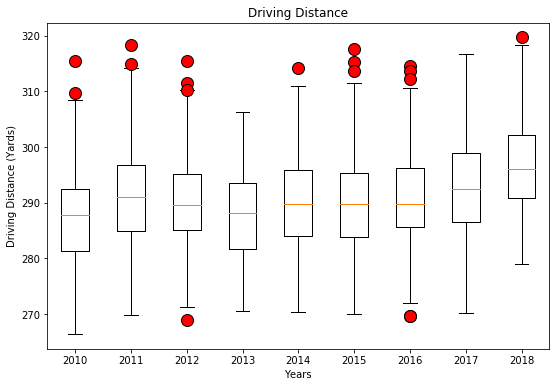

In [14]:

# DRIVING PEFORMANCE
# Boxplot of driving data across years

# Driving Distance - (AVG.)
driv_dist_2010 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2010,"Driving Distance - (AVG.)"]
driv_dist_2011 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2011,"Driving Distance - (AVG.)"]
driv_dist_2012 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2012,"Driving Distance - (AVG.)"]
driv_dist_2013 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2013,"Driving Distance - (AVG.)"]
driv_dist_2014 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2014,"Driving Distance - (AVG.)"]
driv_dist_2015 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2015,"Driving Distance - (AVG.)"]
driv_dist_2016 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2016,"Driving Distance - (AVG.)"]
driv_dist_2017 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2017,"Driving Distance - (AVG.)"]
driv_dist_2018 = cln_all_pga_data_df.loc[cln_all_pga_data_df["Season"]==2018,"Driving Distance - (AVG.)"]

driv_data_boxplot_to_plot = [driv_dist_2010, driv_dist_2011, driv_dist_2012, \
                             driv_dist_2013, driv_dist_2014, driv_dist_2015, \
                             driv_dist_2016, driv_dist_2017, driv_dist_2018]

# Create figure and axes
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

# Create the boxplot
boxplot = ax.boxplot(driv_data_boxplot_to_plot, flierprops=dict(markerfacecolor='r', marker='o', markersize=12.0))
ax.set_xticklabels([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
ax.set(title = "Driving Distance",
       xlabel = "Years",
       ylabel = "Driving Distance (Yards)")
plt.show()

In [15]:
alpha = 1e-3
print("The null hypothesis is that this sample comes from a normal distribution")

print("For 2010 Driving Distance:")
k2, p = st.normaltest(driv_dist_2010)
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
print("--------------------------\n")
print("For 2011 Driving Distance:")
k2, p = st.normaltest(driv_dist_2011)
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
print("--------------------------\n")
print("For 2012 Driving Distance:")
k2, p = st.normaltest(driv_dist_2012)
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
print("--------------------------\n")
print("For 2013 Driving Distance:")
k2, p = st.normaltest(driv_dist_2013)
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
print("--------------------------\n")
print("For 2014 Driving Distance:")
k2, p = st.normaltest(driv_dist_2014)
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
print("--------------------------\n")
print("For 2015 Driving Distance:")
k2, p = st.normaltest(driv_dist_2015)
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
print("--------------------------\n")
print("For 2016 Driving Distance:")
k2, p = st.normaltest(driv_dist_2016)
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
print("--------------------------\n")
print("For 2017 Driving Distance:")
k2, p = st.normaltest(driv_dist_2017)
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
print("--------------------------\n")
print("For 2018 Driving Distance:")
k2, p = st.normaltest(driv_dist_2018)
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
print("--------------------------\n")


The null hypothesis is that this sample comes from a normal distribution
For 2010 Driving Distance:
p = 0.0708698
The null hypothesis cannot be rejected
--------------------------

For 2011 Driving Distance:
p = 0.093565
The null hypothesis cannot be rejected
--------------------------

For 2012 Driving Distance:
p = 0.113096
The null hypothesis cannot be rejected
--------------------------

For 2013 Driving Distance:
p = 0.0384691
The null hypothesis cannot be rejected
--------------------------

For 2014 Driving Distance:
p = 0.478978
The null hypothesis cannot be rejected
--------------------------

For 2015 Driving Distance:
p = 0.208274
The null hypothesis cannot be rejected
--------------------------

For 2016 Driving Distance:
p = 0.50993
The null hypothesis cannot be rejected
--------------------------

For 2017 Driving Distance:
p = 0.393433
The null hypothesis cannot be rejected
--------------------------

For 2018 Driving Distance:
p = 0.166828
The null hypothesis cannot be 

In [44]:
def statistic_ave_top_bottom_over_seasons(base_df, col_name, title ='', ylabel = '', format_prefix = '', format_set='{:,.0f}'):
    just_players_all=base_df.copy()
    just_players_all=just_players_all.drop_duplicates(subset="Player Name", keep="first") 
    player_season_groups=just_players_all.groupby(['Season'])
    
        # Divison by Seasons
    Full_Season_2010 = base_df.loc[base_df["Season"]==2010]
    Full_Season_2011 = base_df.loc[base_df["Season"]==2011]
    Full_Season_2012 = base_df.loc[base_df["Season"]==2012]
    Full_Season_2013 = base_df.loc[base_df["Season"]==2013]
    Full_Season_2014 = base_df.loc[base_df["Season"]==2014]
    Full_Season_2015 = base_df.loc[base_df["Season"]==2015]
    Full_Season_2016 = base_df.loc[base_df["Season"]==2016]
    Full_Season_2017 = base_df.loc[base_df["Season"]==2017]
    Full_Season_2018 = base_df.loc[base_df["Season"]==2018]

     # Top and Bottom 10 Players for each season by the statistic in the column name
    ave_by_season_all=player_season_groups[col_name].mean()
    ave_by_season_all_df = pd.DataFrame(ave_by_season_all)

    Full_Season_2010=Full_Season_2010.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2010 = Full_Season_2010.iloc[0:9]
    Full_Season_2010=Full_Season_2010.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2010 = Full_Season_2010.iloc[0:9]

    Full_Season_2011=Full_Season_2011.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2011 = Full_Season_2011.iloc[0:9]
    Full_Season_2011=Full_Season_2011.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2011 = Full_Season_2011.iloc[0:9]

    Full_Season_2012=Full_Season_2012.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2012 = Full_Season_2012.iloc[0:9]
    Full_Season_2012=Full_Season_2012.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2012 = Full_Season_2012.iloc[0:9]

    Full_Season_2013=Full_Season_2013.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2013 = Full_Season_2013.iloc[0:9]
    Full_Season_2013=Full_Season_2013.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2013 = Full_Season_2013.iloc[0:9]

    Full_Season_2014=Full_Season_2014.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2014 = Full_Season_2014.iloc[0:9]
    Full_Season_2014=Full_Season_2014.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2014 = Full_Season_2014.iloc[0:9]

    Full_Season_2015=Full_Season_2015.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2015 = Full_Season_2015.iloc[0:9]
    Full_Season_2015=Full_Season_2015.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2015 = Full_Season_2015.iloc[0:9]

    Full_Season_2016=Full_Season_2016.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2016 = Full_Season_2016.iloc[0:9]
    Full_Season_2016=Full_Season_2016.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2016 = Full_Season_2016.iloc[0:9]

    Full_Season_2017=Full_Season_2017.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2017 = Full_Season_2017.iloc[0:9]
    Full_Season_2017=Full_Season_2017.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2017 = Full_Season_2017.iloc[0:9]

    Full_Season_2018=Full_Season_2018.sort_values([col_name, "Season"], ascending = (False, True)).reset_index(drop=True)
    Top_10_Season_2018 = Full_Season_2018.iloc[0:9]
    Full_Season_2018=Full_Season_2018.sort_values([col_name, "Season"], ascending = (True, True))
    Bottom_10_Season_2018 = Full_Season_2018.iloc[0:9]
    Top_10_by_season = pd.DataFrame([Top_10_Season_2010[col_name].mean(), 
                   Top_10_Season_2011[col_name].mean(), 
                   Top_10_Season_2012[col_name].mean(), 
                   Top_10_Season_2013[col_name].mean(), 
                   Top_10_Season_2014[col_name].mean(), 
                   Top_10_Season_2015[col_name].mean(), 
                   Top_10_Season_2016[col_name].mean(), 
                   Top_10_Season_2017[col_name].mean(), 
                   Top_10_Season_2018[col_name].mean()])

    Bottom_10_by_season = pd.DataFrame([Bottom_10_Season_2010[col_name].mean(), 
                   Bottom_10_Season_2011[col_name].mean(), 
                   Bottom_10_Season_2012[col_name].mean(), 
                   Bottom_10_Season_2013[col_name].mean(), 
                   Bottom_10_Season_2014[col_name].mean(), 
                   Bottom_10_Season_2015[col_name].mean(), 
                   Bottom_10_Season_2016[col_name].mean(), 
                   Bottom_10_Season_2017[col_name].mean(), 
                   Bottom_10_Season_2018[col_name].mean()])

    #Merging data frames for All Players, Top 10, and Bottom 10 
     #season_years_df is from above
    ave_by_season_all_df=ave_by_season_all_df.reset_index(drop=True)

    ave_line_graph=pd.merge(season_years_df, ave_by_season_all_df, right_index=True, left_index=True, suffixes=("A", "B"))
    ave_line_graph=pd.merge(ave_line_graph, Top_10_by_season, right_index=True, left_index=True, suffixes=("C", "D"))
    ave_line_graph=pd.merge(ave_line_graph, Bottom_10_by_season, right_index=True, left_index=True, suffixes=("E", "F"))

    # Rename Columns
    ave_line_graph.columns = ['Season', 'All Players', 'Top 10 Players', 'Bottom 10 Players']

    #Add index with years
    ave_line_graph.set_index('Season', inplace = True)


    ax= sns.lineplot(data=ave_line_graph, markers= True)
    ax.set(xlabel='Season', ylabel=ylabel, title=title)
    #changing ylables ticks
    y_value=[format_prefix + format_set.format(x) for x in ax.get_yticks()]
    ax.set_yticklabels(y_value)
    ax.legend(loc='center right', bbox_to_anchor=(1.45, 0.5), ncol=1)


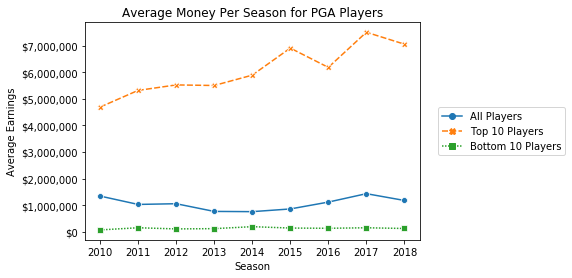

In [45]:
statistic_ave_top_bottom_over_seasons(cln_all_pga_data_df, "Total Money (Official and Unofficial) - (MONEY)", ylabel='Average Earnings', title='Average Money Per Season for PGA Players', format_prefix = "$")

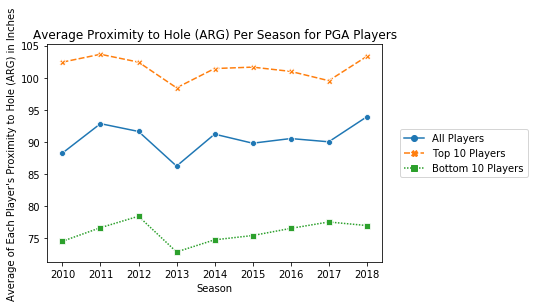

In [46]:
statistic_ave_top_bottom_over_seasons(cln_all_pga_data_df, "Proximity to Hole (ARG) - (AVG DTP) (IN)", title='Average Proximity to Hole (ARG) Per Season for PGA Players', ylabel='''Average of Each Player's Proximity to Hole (ARG) in Inches''', format_prefix = "")

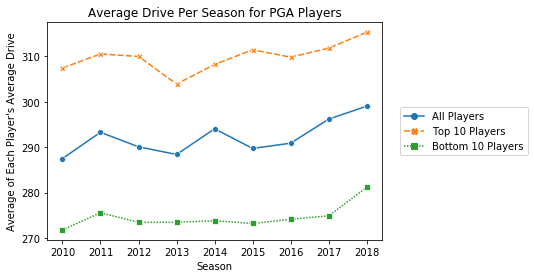

In [47]:
statistic_ave_top_bottom_over_seasons(cln_all_pga_data_df, "Driving Distance - (AVG.)", ylabel='''Average of Each Player's Average Drive''', title='Average Drive Per Season for PGA Players', format_prefix = "")

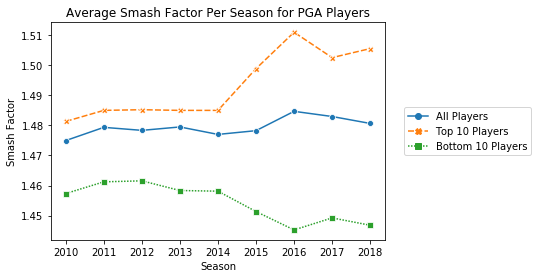

In [50]:
statistic_ave_top_bottom_over_seasons(cln_all_pga_data_df, "Smash Factor - (AVG.)", ylabel='Smash Factor', title='Average Smash Factor Per Season for PGA Players', format_prefix = "", format_set='{:,.2f}')

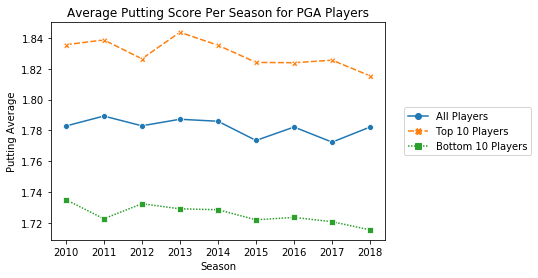

In [51]:
statistic_ave_top_bottom_over_seasons(cln_all_pga_data_df, "Putting Average - (AVG)", ylabel='Putting Average', title='Average Putting Score Per Season for PGA Players', format_prefix = "", format_set='{:,.2f}')